<a href="https://colab.research.google.com/github/Hashwineey/STQD6324_Data_Management_Assignment01/blob/main/Part3_Predictive_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Hi and welcome to Part 3 — the final section of this project! Previously, we cleaned the raw dataset and performed EDA using HiveSQL in Jupyter Notebook. Now, to make sure this project fulfills its objectives *and* brings value to real-world problems, we’ll move on to Predictive Modeling. In this part, we’ll prepare the cleaned dataset for both KNN and Logistic Regression models. Then, we’ll compare their performance to decide which model works best for prediction. Once that’s done, the final model will be ready to support real-life banking problem-solving!**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Libraries

In [2]:
import pandas as pd
import numpy as np

# For visualization:
import matplotlib.pyplot as plt
import seaborn as sns

# For Predictive Modelling
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import datasets, neighbors, linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

### Load the dataset

In [3]:
df = pd.read_csv('/content/drive/MyDrive/STQD6324_Data Management/adult_income_datasets/adult_cleaned.csv')
df.head()

,age,workclass,fnlwgt,education_num,marital_status,relationship,race,sex,capital_gain,capital_loss,hours_per_week,income,education_grouped,occupation_grouped,native_region,age_group
0,39,government,77516,13,single,not-in-family,white,male,2174,0,40,<=50k,higher_edu,admin_support_sales,north_america,36–45
1,50,self-employed,83311,13,married,husband,white,male,0,0,13,<=50k,higher_edu,white_collar,north_america,46–60
2,38,private,215646,9,separated,not-in-family,white,male,0,0,40,<=50k,high_school_grad,manual_labor,north_america,36–45
3,53,private,234721,7,married,husband,black,male,0,0,40,<=50k,primary,manual_labor,north_america,46–60
4,28,private,338409,13,married,wife,black,female,0,0,40,<=50k,higher_edu,white_collar,central_america,26–35


### Preprocess the data before modeling

#### 1. Drop unnecessary columns

In [4]:
df = df.drop(columns=['fnlwgt', 'race', 'sex','age','workclass','education_num','relationship'])
df.head()

,marital_status,capital_gain,capital_loss,hours_per_week,income,education_grouped,occupation_grouped,native_region,age_group
0,single,2174,0,40,<=50k,higher_edu,admin_support_sales,north_america,36–45
1,married,0,0,13,<=50k,higher_edu,white_collar,north_america,46–60
2,separated,0,0,40,<=50k,high_school_grad,manual_labor,north_america,36–45
3,married,0,0,40,<=50k,primary,manual_labor,north_america,46–60
4,married,0,0,40,<=50k,higher_edu,white_collar,central_america,26–35


#### 2. Encode income

In [5]:
df['income'].unique()

array(['<=50k', '>50k'], dtype=object)

In [6]:
df['income'] = df['income'].str.strip().map({'<=50k': 0, '>50k': 1})
df.head()

,marital_status,capital_gain,capital_loss,hours_per_week,income,education_grouped,occupation_grouped,native_region,age_group
0,single,2174,0,40,0,higher_edu,admin_support_sales,north_america,36–45
1,married,0,0,13,0,higher_edu,white_collar,north_america,46–60
2,separated,0,0,40,0,high_school_grad,manual_labor,north_america,36–45
3,married,0,0,40,0,primary,manual_labor,north_america,46–60
4,married,0,0,40,0,higher_edu,white_collar,central_america,26–35


In [7]:
df['income'].value_counts()

,count
income,
0,24698
1,7839


#### 3. One-hot encode categorical variables
+ We need to encode categorical variables because KNN uses distance-based calculations. Hence, the program won't be able to calculate distance between "single" and "north_america"

In [8]:
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded.head()

,capital_gain,capital_loss,hours_per_week,income,marital_status_separated,marital_status_single,marital_status_widowed,education_grouped_high_school_grad,education_grouped_higher_edu,education_grouped_no_schooling,...,native_region_europe,native_region_north_america,native_region_other,native_region_south_america,age_group_26–35,age_group_36–45,age_group_46–60,age_group_61–75,age_group_76+,age_group_<18
0,2174,0,40,0,False,True,False,False,True,False,...,False,True,False,False,False,True,False,False,False,False
1,0,0,13,0,False,False,False,False,True,False,...,False,True,False,False,False,False,True,False,False,False
2,0,0,40,0,True,False,False,True,False,False,...,False,True,False,False,False,True,False,False,False,False
3,0,0,40,0,False,False,False,False,False,False,...,False,True,False,False,False,False,True,False,False,False
4,0,0,40,0,False,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,False


In [9]:
# Convert all the columns to integer
df_encoded = df_encoded.astype(int)
df_encoded.head()

,capital_gain,capital_loss,hours_per_week,income,marital_status_separated,marital_status_single,marital_status_widowed,education_grouped_high_school_grad,education_grouped_higher_edu,education_grouped_no_schooling,...,native_region_europe,native_region_north_america,native_region_other,native_region_south_america,age_group_26–35,age_group_36–45,age_group_46–60,age_group_61–75,age_group_76+,age_group_<18
0,2174,0,40,0,0,1,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0
1,0,0,13,0,0,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0
2,0,0,40,0,1,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
3,0,0,40,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,0,0,40,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


### Scale and Split the data into training and testing set

In [10]:
# Drop the target variable
X = df_encoded.drop("income", axis=1)
y = df_encoded["income"]

# Separate numeric and one-hot columns
numeric_cols = ['capital_gain', 'capital_loss', 'hours_per_week']
onehot_cols = [col for col in X.columns if col not in numeric_cols]

# Apply StandardScaler only to numeric columns
scaler = StandardScaler()
X_scaled_numeric = scaler.fit_transform(X[numeric_cols])
X_scaled_numeric_df = pd.DataFrame(X_scaled_numeric, columns=numeric_cols, index=X.index)

# Combine scaled numeric + untouched one-hot
X_final = pd.concat([X_scaled_numeric_df, X[onehot_cols]], axis=1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.3, random_state=42)

### Build KNN Model

In [13]:
# Train the model
knn = KNeighborsClassifier(n_neighbors=5)
calibrated_knn = CalibratedClassifierCV(knn, method='sigmoid', cv=5)
calibrated_knn.fit(X_train, y_train)

# Predict
y_pred = calibrated_knn.predict(X_test)

#### Evaluate KNN Model

In [14]:
# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"KNN Accuracy: {accuracy:.4f}")

# Confusion Matrix
print("\nConfusion Matrix (KNN):\n", confusion_matrix(y_test, y_pred))

# Classification Report (includes precision, recall, F1)
print("\nClassification Report (KNN):\n", classification_report(y_test, y_pred))

# Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"\nMean Squared Error (KNN): {mse:.4f}")

KNN Accuracy: 0.8402

Confusion Matrix (KNN):
 [[6960  445]
 [1115 1242]]

Classification Report (KNN):
               precision    recall  f1-score   support

           0       0.86      0.94      0.90      7405
           1       0.74      0.53      0.61      2357

    accuracy                           0.84      9762
   macro avg       0.80      0.73      0.76      9762
weighted avg       0.83      0.84      0.83      9762


Mean Squared Error (KNN): 0.1598


### Build Logistic Regression Model

In [15]:
# Train the model
base_model = LogisticRegression(class_weight='balanced', max_iter=1000)
calibrated_model = CalibratedClassifierCV(base_model, method='sigmoid', cv=5)
calibrated_model.fit(X_train, y_train)

# Predict
y_pred_logreg = calibrated_model.predict(X_test)

#### Evaluate LogReg Model

In [16]:
# Accuracy Score
logreg_acc = accuracy_score(y_test, y_pred_logreg)
print(f"Logistic Regression Accuracy: {logreg_acc:.4f}")

# Confusion Matrix
print("\nConfusion Matrix (Logistic Regression):\n", confusion_matrix(y_test, y_pred_logreg))

# Classification Report
print("\nClassification Report (Logistic Regression):\n", classification_report(y_test, y_pred_logreg))

# Mean Squared Error
mse_logreg = mean_squared_error(y_test, y_pred_logreg)
print(f"Mean Squared Error (Logistic Regression): {mse_logreg:.4f}")

Logistic Regression Accuracy: 0.8561

Confusion Matrix (Logistic Regression):
 [[6922  483]
 [ 922 1435]]

Classification Report (Logistic Regression):
               precision    recall  f1-score   support

           0       0.88      0.93      0.91      7405
           1       0.75      0.61      0.67      2357

    accuracy                           0.86      9762
   macro avg       0.82      0.77      0.79      9762
weighted avg       0.85      0.86      0.85      9762

Mean Squared Error (Logistic Regression): 0.1439


### ROC Curve for KNN vs Logistic Regression

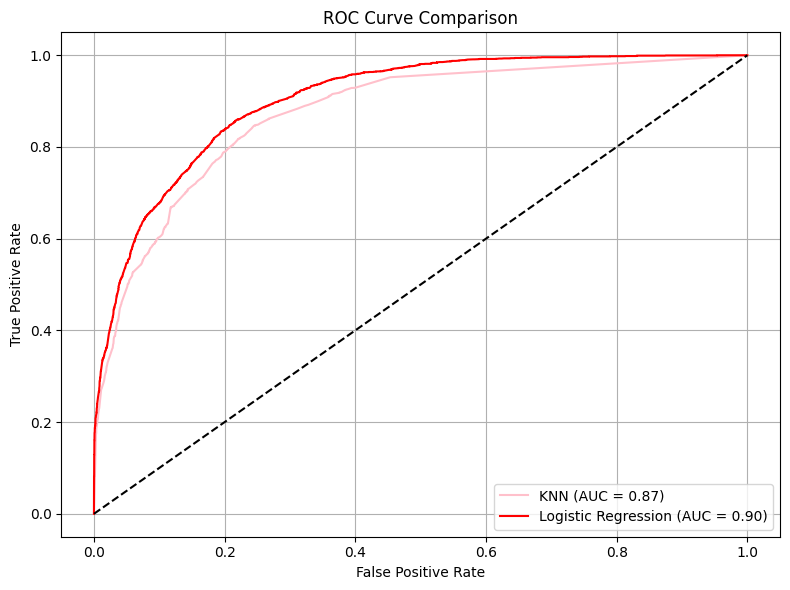

In [17]:
# Predict probabilities
y_scores_knn = calibrated_knn.predict_proba(X_test)[:, 1]
y_scores_logreg = calibrated_model.predict_proba(X_test)[:, 1]

# ROC Curve
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_scores_knn)
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_scores_logreg)
roc_auc_knn = auc(fpr_knn, tpr_knn)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

# Plot ROC
plt.figure(figsize=(8,6))
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {roc_auc_knn:.2f})', color='pink')
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {roc_auc_logreg:.2f})', color='red')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

### Summary of the Model Results

+ **Overall Evaluation Scores:**

| Metric                  | KNN          | Logistic Regression |
|------------------------|--------------|---------------------|
| Accuracy               | 84.02%       | 85.61%              |
| Mean Squared Error     | 0.1598       | 0.1439              |
| Precision (>50K)       | 0.74         | 0.75                |
| Recall (>50K)          | 0.53         | 0.61                |
| F1-Score (>50K)        | 0.61         | 0.67                |
| AUC Score              | 0.87         | 0.90                |

+ **ROC Curve Shape:**
    + Both ROC curves demonstrate better-than-random classification (above the diagonal baseline).
    + The red line (Logistic Regression) hugs the top-left corner more than KNN, indicating stronger performance, especially at higher sensitivity levels.

+ **Conclusion:**
    + While KNN provided decent classification, **Logistic Regression outperformed KNN** in nearly all aspects, including AUC score, precision, recall, F1-score, and overall accuracy.
    + Logistic Regression is also **more interpretable and scalable**, making it the better choice for this income classification task, especially in banking applications where understanding the reasoning behind predictions is important.

### Feature Importance from Logistic Regression Model
+ Understanding which features influence the predictions of a logistic regression model is crucial for interpretability and model improvement.
+ To analyze a logistic regression model and enhance its performance, one must comprehend the significance of each variable.

In [18]:
# Refit the original logistic regression just for interpretability
logreg_interpret = LogisticRegression(max_iter=1000, class_weight='balanced')
logreg_interpret.fit(X_train, y_train)

# Get feature importance
importance = pd.Series(logreg_interpret.coef_[0], index=X_train.columns)
top_positive = importance.sort_values(ascending=False).head(10)
top_negative = importance.sort_values().head(10)

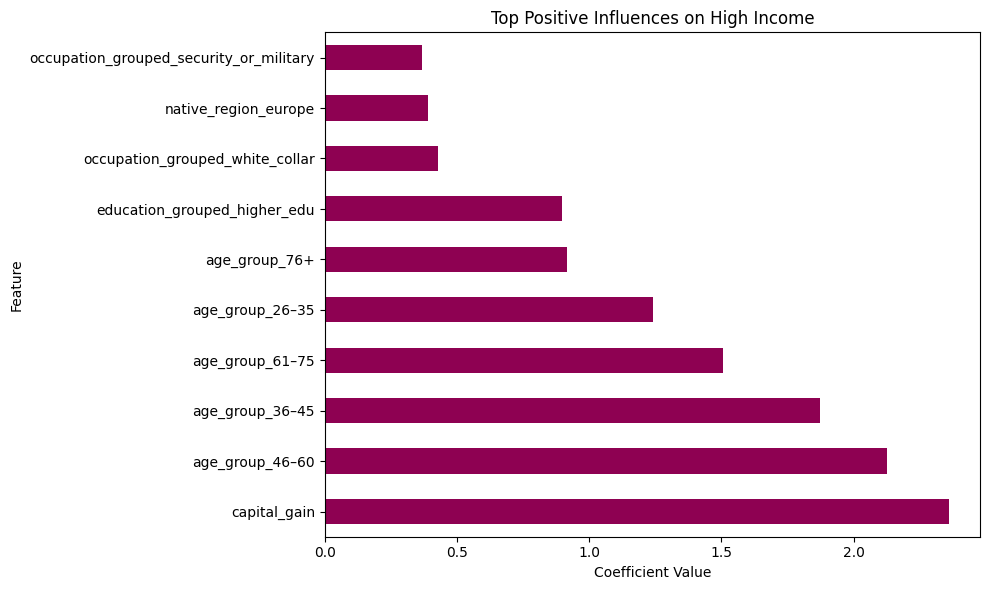

In [19]:
# Display top 10 positive features
plt.figure(figsize=(10,6))
top_positive.plot(kind='barh', title='Top Positive Influences on High Income', cmap = 'PiYG')
plt.xlabel('Coefficient Value')
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

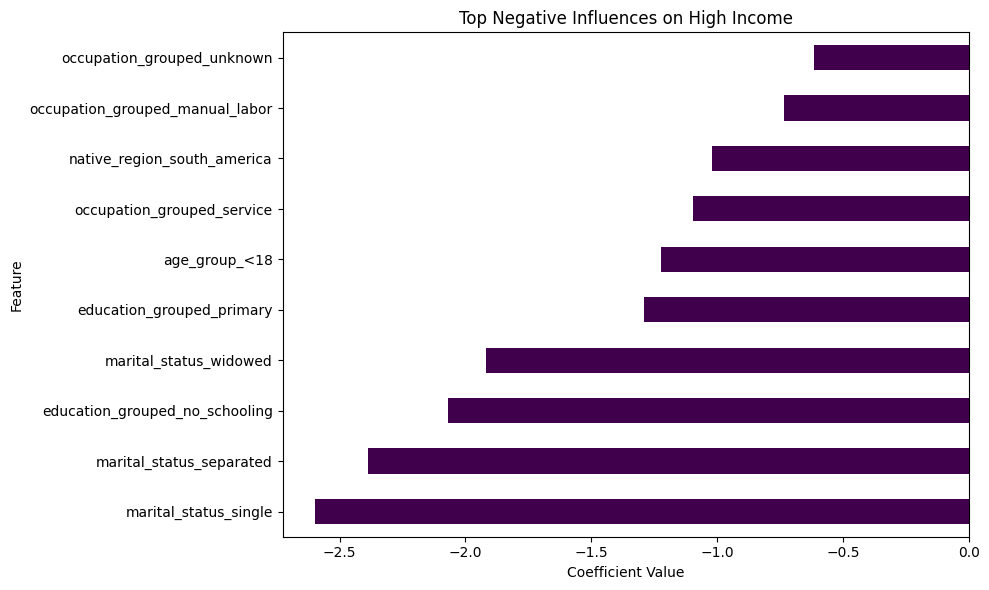

In [20]:
# Display bottom 10 Negative influences
plt.figure(figsize=(10,6))
top_negative.plot(kind='barh', title='Top Negative Influences on High Income', cmap = 'PRGn')
plt.xlabel('Coefficient Value')
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

The logistic regression model reveals some clear drivers of high income:

**Strong Positive Influences:**
+ Age groups 46–60 and 36–45 stand out the most, suggesting mid-career individuals have higher odds of earning >USD50K.
+ Individuals with higher education shows the importance of advanced education in gaining higher income.
+ White collar and security/military occupational roles are also positively correlated.
+ Even native_region "europe" appears slightly more likely to predict high income.

**Strong Negative Influences:**
+ marital_status "single", "separated" and "widowed" seems to reduce the likelihood of earning >USD50K. This could possibly due to household structure or financial stability.
+ education_grouped "primary" and occupation_grouped "manual_labor/service" also point toward lower income potential.
+ Individuals from native_region "central_america" and <18 age group unsurprisingly show negative correlation.

**What is in it for the banking industry?**
+ These traits can help banks:
    + Pre-qualify customers for credit or premium financial products.
    + Segment users by income potential for targeted campaigns.
    + Promote financial literacy or upskilling programs to lower-income segments.

### Prediction using Logistic Regression Model (logreg)

#### 1. Create dataframe for a set of 2 new individuals

In [21]:
df_encoded.columns

Index(['capital_gain', 'capital_loss', 'hours_per_week', 'income',
       'marital_status_separated', 'marital_status_single',
       'marital_status_widowed', 'education_grouped_high_school_grad',
       'education_grouped_higher_edu', 'education_grouped_no_schooling',
       'education_grouped_primary', 'occupation_grouped_blue_collar',
       'occupation_grouped_manual_labor',
       'occupation_grouped_security_or_military', 'occupation_grouped_service',
       'occupation_grouped_unknown', 'occupation_grouped_white_collar',
       'native_region_central_america', 'native_region_europe',
       'native_region_north_america', 'native_region_other',
       'native_region_south_america', 'age_group_26–35', 'age_group_36–45',
       'age_group_46–60', 'age_group_61–75', 'age_group_76+', 'age_group_<18'],
      dtype='object')

In [22]:
new_people = pd.DataFrame({
    'capital_gain': [0, 0, 0],
    'capital_loss': [0, 0, 0],
    'hours_per_week': [40, 40, 10],
    'marital_status_separated': [0, 0, 0],
    'marital_status_single': [1, 0, 1],
    'marital_status_widowed': [0, 1, 0],
    'education_grouped_high_school_grad': [0, 1, 0],
    'education_grouped_higher_edu': [1, 0, 0],
    'education_grouped_no_schooling': [0, 0, 1],
    'education_grouped_primary': [0, 0, 0],
    'occupation_grouped_blue_collar': [0, 0, 0],
    'occupation_grouped_manual_labor': [0, 1, 0],
    'occupation_grouped_security_or_military': [0, 0, 0],
    'occupation_grouped_service': [0, 0, 0],
    'occupation_grouped_unknown': [0, 0, 1],
    'occupation_grouped_white_collar': [1, 0, 0],
    'native_region_central_america': [1, 0, 0],
    'native_region_europe': [0, 0, 0],
    'native_region_north_america': [0, 1, 0],
    'native_region_other': [0, 0, 0],
    'native_region_south_america': [0, 0, 1],
    'age_group_26–35': [1, 0, 0],
    'age_group_36–45': [0, 0, 0],
    'age_group_46–60': [0, 1, 0],
    'age_group_61–75': [0, 0, 0],
    'age_group_76+': [0, 0, 0],
    'age_group_<18': [0, 0, 1]
})

In [23]:
new_people

,capital_gain,capital_loss,hours_per_week,marital_status_separated,marital_status_single,marital_status_widowed,education_grouped_high_school_grad,education_grouped_higher_edu,education_grouped_no_schooling,education_grouped_primary,...,native_region_europe,native_region_north_america,native_region_other,native_region_south_america,age_group_26–35,age_group_36–45,age_group_46–60,age_group_61–75,age_group_76+,age_group_<18
0,0,0,40,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,40,0,0,1,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2,0,0,10,0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1


#### 2. Predict the income class (0 = <=50K, 1 = >50K)

In [24]:
predicted_classes = calibrated_model.predict(new_people)
print("Predicted Income Classes:", predicted_classes)

Predicted Income Classes: [1 1 0]


#### 3. Predict the probabilities

In [25]:
predicted_probs = calibrated_model.predict_proba(new_people)
print("Probability of >50K Income:", predicted_probs[:, 1])

Probability of >50K Income: [0.99998862 0.99998346 0.0059501 ]


### Prediction on New Individuals

To evaluate the robustness of the final calibrated logistic regression model, we tested it on three hypothetical individuals with distinct demographic profiles:

| Person | Summary                                                                 |
|--------|-------------------------------------------------------------------------|
| 1️      | Higher education, white collar, 40 hrs/week, age 26–35                  |
| 2      | High school graduate, manual labor, 40 hrs/week, age 46–60              |
| 3      | No schooling, unknown occupation, 10 hrs/week, age <18                  |

The predicted income class and probabilities were:

- **Person 1**: >50K income | **Probability**: 99.9989%
- **Person 2**: >50K income | **Probability**: 99.9983%
- **Person 3**: ≤50K income | **Probability**: 0.59%

These results reflect the model's ability to **accurately differentiate income likelihood** based on relevant demographic and work-related features. It confidently assigns high-income probability to individuals with strong indicators (education, occupation, work hours), while correctly classifying the underqualified profile (Person 3) as low income.

This not only validates the model's training logic but also shows its **potential usability in real-world banking applications**, such as customer segmentation, loan product eligibility, or marketing for high net-worth services.


## THE END!